In [2]:
import os

# ---------------------------------- #
# Scikit-learn and related libraries #
# ---------------------------------- #
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# ---------- #
# Tensorflow #
# ---------- #
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
tf.random.set_seed(seed=42)

# ---------------------- #
# User defined libraries #
# ---------------------- #
import util
import confmatrix

# __Jumio Take-Home Assignment__

## __Abstract__
***

We build a classifier on the MNIST dataset. Our classifier is a convolutional neural network with three convolutional layers and one dense layer. With a threshold-based decision strategy, our classifier achieves a maximum false positive rate of __0.00015__ for each class in a test set with at least 1000 images per class. The coverage of our decision strategy is $88\%$. 

__Author__: Faerlin Pulido <br>
__GitHub__: https://github.com/faerlinpulido/jumio_take_home_assignment/blob/master/jumio_assignment.ipynb

## __Data__
***

__Name__: MNIST <br>
__Description__: Gray-scale images of hand-drawn digits from zero through nine. Each image is a $28\times28$ image where each pixel indicates its lightness or darkness. The pixel-value is an integer ranging from 0 to 255. <br>
__Source__: Provided data file <code>mnist.csv</code>

We begin by fetching the data into a dataframe.

In [3]:
filepath = os.path.join('data', 'mnist.csv')
df = pd.read_csv(filepath)

To get a sense of our data, print the first five rows of the dataframe and determine the total number of rows.

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(df)

42000

The dataframe contains 42000 images. Each row represents an image with a label (between 0 and 9) and 784 pixel values (between 0 and 255). Below, we show how many images for each label are present in our dataframe.

In [5]:
df['label'].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

Next, we separate the images from the target labels and store them into numpy arrays. 

In [6]:
Y = df['label'].to_numpy()
X = df.drop('label', axis=1).to_numpy()

We reshape <code>X</code> to a 3-dimensional matrix where the third dimension indicates the number of channels. This is the shape that convolutional layers expects in Tensorflow. 

In [7]:
X = np.reshape(X, [42000, 28, 28, 1])
X.shape

(42000, 28, 28, 1)

To visualize the images in our data, we plot 50 of them below using our utility function <code>plot_images()</code>.

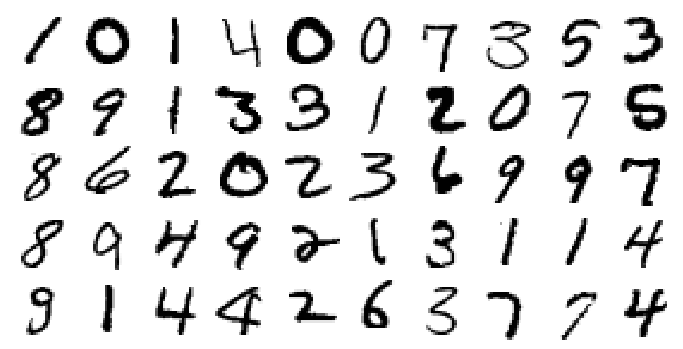

In [8]:
util.plot_images(X[:50], 28, images_per_row=10)

## __Data Processing__
***

We split our data into three sets: training set (<code>X_train</code>), validation set (<code>X_valid</code>), and test set (<code>X_test</code>). We also create a variable called <code>X_train_and_valida</code>, which simply contains the images of the training and validation set. 

The prototype of our model will be trained on <code>X_train</code> and validated on <code>X_valid</code> to tune for the number of epochs. Then we will retrain our model on <code>X_train_and_valid</code> to obtain our final model, which will be evaluated on <code>X_test</code>. 

The stratified splitting of our data into these different sets is done by <code>sklearn.model_selection.train_test_split</code>.

In [9]:
X_train_and_valid, X_test, Y_train_and_valid, Y_test = train_test_split(X, Y, test_size=0.35, stratify=Y, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_and_valid, Y_train_and_valid, test_size=0.20, stratify=Y_train_and_valid, random_state=42)

Below, we show the number of images belonging to each class in our training, validation, and test sets. Note that the test set has at least 1000 images per class. 

In [10]:
print("Training set")
for i in range(10):
    print("Class %d has %d images" % (i, len(np.where(Y_train == i)[0])))
print("Total: " + str(len(Y_train)))

Training set
Class 0 has 2149 images
Class 1 has 2435 images
Class 2 has 2172 images
Class 3 has 2262 images
Class 4 has 2117 images
Class 5 has 1974 images
Class 6 has 2151 images
Class 7 has 2289 images
Class 8 has 2113 images
Class 9 has 2178 images
Total: 21840


In [11]:
print("Validation set")
for i in range(10):
    print("Class %d has %d images" % (i, len(np.where(Y_valid == i)[0])))
print("Total: " + str(len(Y_valid)))

Validation set
Class 0 has 537 images
Class 1 has 609 images
Class 2 has 543 images
Class 3 has 566 images
Class 4 has 530 images
Class 5 has 493 images
Class 6 has 538 images
Class 7 has 572 images
Class 8 has 528 images
Class 9 has 544 images
Total: 5460


In [12]:
print("Test set")
for i in range(10):
    print("Class %d has %d images" % (i, len(np.where(Y_test == i)[0])))
print("Total: " + str(len(Y_test)))

Test set
Class 0 has 1446 images
Class 1 has 1640 images
Class 2 has 1462 images
Class 3 has 1523 images
Class 4 has 1425 images
Class 5 has 1328 images
Class 6 has 1448 images
Class 7 has 1540 images
Class 8 has 1422 images
Class 9 has 1466 images
Total: 14700


Next, we one-hot encode our label vectors using <code>tensorflow.keras.utils.to_categorical</code>

In [13]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_train_and_valid = to_categorical(Y_train_and_valid)
Y_test = to_categorical(Y_test)

As a form of regularization, we train our images on augmented images. We use tensorflow's <code>ImageDataGenerator</code> to apply these transformations at training time. Below, we define two functions: one returns a generator that applies augmentations (rescale, rotation, and sheer) and the other returns a generator that applies rescaling only. 

The training image generator <code>train_generator</code> applies augmentations on the images of the training set at training time. The validation image generator <code>valid_generator</code> applies rescaling only. 

In [14]:
def get_generator_with_augmentation(X, Y, batch_size):
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=22.5, 
        shear_range=0.2)
    generator = datagen.flow(X, Y, batch_size=batch_size)
    return generator

def get_generator_without_augmentation(X, Y, batch_size):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    generator = datagen.flow(X, Y, batch_size=batch_size)
    return generator

In [15]:
batch_size = 32
train_generator = get_generator_with_augmentation(X_train, Y_train, batch_size)
valid_generator = get_generator_without_augmentation(X_valid, Y_valid, batch_size)
train_and_valid_generator = get_generator_with_augmentation(X_train_and_valid, Y_train_and_valid, batch_size)

For evaluation, we don't need to create a generator for the test set. We simply rescale the pixel values. 

In [16]:
X_test = X_test / 255.0

## __CNN Model__
***

Our model is a basic convolutional neural network taken from Chollet, 2018. Its convolutional base is made up of <code>Conv2D</code> and <code>MaxPooling2D</code> layers. On top of this convolutional base, we attach a dense layer with a softmax activation function. This model is defined below as <code>MyModel</code>. 

In [17]:
class MyModel(tf.keras.Model):
   
    def __init__(self, input_shape, number_of_classes):
        
        super(MyModel, self).__init__()
      
        # Convolutional Base
        self.conv_A = Conv2D(32, (3,3), activation='relu', input_shape=input_shape)
        self.max_pool_A = MaxPooling2D((2,2))
        self.conv_B = Conv2D(64, (3,3), activation='relu')
        self.max_pool_B = MaxPooling2D((2,2))
        self.conv_C = Conv2D(64, (3,3), activation='relu')
        
        # Add classifier on top of base
        self.flatten = Flatten()
        self.dense = Dense(128, activation='relu')
        self.out = Dense(number_of_classes, activation='softmax')
         
    def call(self, x):
        x = self.conv_A(x)
        x = self.max_pool_A(x)
        x = self.conv_B(x)
        x = self.max_pool_B(x)
        x = self.conv_C(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.out(x)
        return x

## __Train Prototype__
***

In this section, we build and train prototype version of <code>MyModel</code>. It's a prototype because we are not training it on the full of images available to us. Instead, we will train this model on <code>X_train</code> and validated on <code>X_valid</code> to determine the number of epoch that avoids overfitting. In other words, we are tuning for the optimal number of epochs that would create a model that generalizes better. 

In [18]:
image_dim = 28
channels = 1
num_classes = 10
batch_size = 32
input_shape = (image_dim, image_dim, channels)

model = MyModel(input_shape, num_classes)
model.build(input_shape=(batch_size, image_dim, image_dim, channels))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[categorical_accuracy])

Next, we create a <code>saved</code> folder where we store the saved weights and histories of our fits. 

In [19]:
saved_folder = 'saved'
if (not os.path.exists(saved_folder)):
    os.makedirs(saved_folder)
history_filepath = os.path.join(saved_folder, 'history_train.log')

If <code>history_filepath</code> already exists in the <code>saved</code> folder, we simply load it. Otherwise, we call <code>model.fit_generator()</code> to train our model. 

In [20]:
if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    epochs = 20
    train_steps_per_epoch = len(X_train)//batch_size
    valid_steps_per_epoch = len(X_valid)//batch_size
    csvlogger = CSVLogger(history_filepath)
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=valid_steps_per_epoch, 
        callbacks=[csvlogger]).history

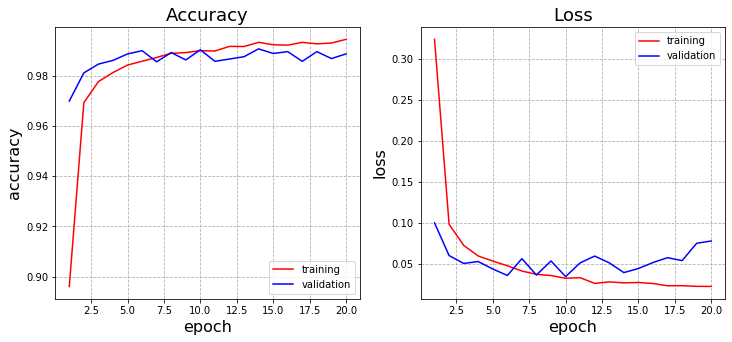

In [21]:
util.plot_accuracy_loss(history)

As expected, the training accuracy increases and training loss decreases with every epoch. On the other hand, the validation accuracy seem to reach a ceiling while the validation loss decreases, then reaches a minimum at around epoch=10, then increases with epoch. Beyond this minimum, the model is overoptimizing on the training data (overfitting). To buid a model that generalizes well outside of the training data, we will train a model with __10 epochs__.  

## __Train Final Model__
***

Following from the discussion above, we create a new instance of <code>MyModel</code> and train on it on the full available non-test set, (<code>X_train_and_valid</code>) for 10 epochs. 

In [22]:
epochs = 10
model = MyModel(input_shape, num_classes)
model.build(input_shape=(batch_size, image_dim, image_dim, channels))
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[categorical_accuracy])

If we have the weights and history files already stored in the <code>saved</code> folder, simply load them; otherwise, we peform the fit. 

In [23]:
history_filepath = os.path.join(saved_folder, 'history_full_train_set.log')
weights_filepath = os.path.join(saved_folder, 'weights_full_train_set.h5')
if (os.path.exists(weights_filepath)):
    model.load_weights(weights_filepath)
else:
    csvlogger = CSVLogger(history_filepath)
    train_and_valid_steps_per_epoch = len(X_train_and_valid)//batch_size
    history = model.fit_generator(
        train_and_valid_generator,
        steps_per_epoch=train_and_valid_steps_per_epoch,
        epochs=epochs,
        callbacks=[csvlogger]).history
    model.save_weights(weights_filepath)

To evaluate the performance of our model, we compute the following:
- confusion matrix
- per class FPR
- per class TPR
on the test set <code>X_test</code>. 

In [24]:
Y_pred = model.predict(X_test)

The confusion matrix is shown below:

In [25]:
Y_pred_ = np.argmax(Y_pred, axis=1)
Y_pred_ = np.argmax(Y_pred, axis=1)
Y_test_ = np.argmax(Y_test, axis=1)
conf_mx = metrics.confusion_matrix(Y_test_, Y_pred_)
conf_mx

array([[1435,    0,    1,    0,    0,    1,    6,    0,    1,    2],
       [   0, 1631,    2,    0,    1,    0,    0,    3,    3,    0],
       [   0,    4, 1445,    1,    2,    0,    0,    8,    2,    0],
       [   1,    1,    4, 1505,    0,    3,    0,    7,    1,    1],
       [   0,    1,    1,    0, 1410,    0,    1,    1,    1,   10],
       [   2,    0,    0,    3,    2, 1291,   11,    3,   12,    4],
       [   0,    1,    0,    0,    2,    0, 1442,    0,    3,    0],
       [   0,    2,    6,    0,    6,    0,    0, 1524,    0,    2],
       [   0,    0,    1,    1,    4,    0,    0,    1, 1411,    4],
       [   1,    0,    0,    0,    3,    1,    0,   10,    2, 1449]])

To compute the TPR and FPR per class, we make use of <code>confmatrix.get_true_positive_rate</code> and <code>confmatrix.get_false_positive_rate</code>. Refer to the appendix of this notebook for a short discussion on how this is implemented and refer to <code>confmatrix.py</code> for the source code. 

In [26]:
for class_index in range(10):
    tpr = confmatrix.get_true_positive_rate(class_index, conf_mx)
    fpr = confmatrix.get_false_positive_rate(class_index, conf_mx)
    print("Class %d: TPR=%0.4f FPR=%0.8f" % (class_index, tpr, fpr))

Class 0: TPR=0.9924 FPR=0.00030180
Class 1: TPR=0.9945 FPR=0.00068913
Class 2: TPR=0.9884 FPR=0.00113310
Class 3: TPR=0.9882 FPR=0.00037945
Class 4: TPR=0.9895 FPR=0.00150659
Class 5: TPR=0.9721 FPR=0.00037392
Class 6: TPR=0.9959 FPR=0.00135829
Class 7: TPR=0.9896 FPR=0.00250760
Class 8: TPR=0.9923 FPR=0.00188281
Class 9: TPR=0.9884 FPR=0.00173795


In the next section below, we define a decision strategy that will improve the the FPR our model to a maximum of __0.00015__ for each class in the test set. 

## __Final Model with Decision Strategy__
***

We will define a decision strategy to improve the FPR of our model to a maximum of __0.00015__ for each class in the test set. Given a prediction $y$ from our model, the new prediction $h(y)$ will be

$$
h(y) = 
\begin{cases} 
    \text{argmax}(y) &, \text{if}\ \max(y) \ge \text{threshold} \\
    \text{not_sure} &, \text{otherwise}
\end{cases}
$$

for some threshold. For our model and test set, we find that $\text{threshold} = 0.999975$ accomplishes our goal. Carrying over the predictions (<code>Y_pred</code>) from the previous section, this new decision strategy is implemented below, 

In [27]:
Y_test_ = []
Y_pred_ = []
threshold = 0.999975
for i in range(len(Y_pred)):
    pred = Y_pred[i]
    if (max(pred) >= threshold):
        Y_pred_.append(Y_test[i])
        Y_test_.append(Y_pred[i])
Y_test_ = np.array(Y_test_)
Y_pred_ = np.array(Y_pred_)

The new confusion matrix, per class TPR and per class FPR after applying our new decision strategy are then given by

In [28]:
Y_pred_ = np.argmax(Y_pred_, axis=1)
Y_test_ = np.argmax(Y_test_, axis=1)
conf_mx = metrics.confusion_matrix(Y_test_, Y_pred_)
conf_mx

array([[1352,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1528,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1195,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1382,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0, 1299,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0, 1048,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1359,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1288,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1290,    0],
       [   0,    0,    0,    0,    1,    0,    0,    0,    0, 1245]])

In [29]:
for class_index in range(10):
    tpr = confmatrix.get_true_positive_rate(class_index, conf_mx)
    fpr = confmatrix.get_false_positive_rate(class_index, conf_mx)
    print("Class %d: TPR=%0.4f FPR=%0.8f" % (class_index, tpr, fpr))

Class 0: TPR=1.0000 FPR=0.00000000
Class 1: TPR=1.0000 FPR=0.00000000
Class 2: TPR=1.0000 FPR=0.00008478
Class 3: TPR=1.0000 FPR=0.00008615
Class 4: TPR=0.9992 FPR=0.00008554
Class 5: TPR=0.9990 FPR=0.00000000
Class 6: TPR=1.0000 FPR=0.00000000
Class 7: TPR=0.9992 FPR=0.00000000
Class 8: TPR=1.0000 FPR=0.00000000
Class 9: TPR=0.9992 FPR=0.00008515


We also compute the coverage of our decision strategy.

In [30]:
total_examples = len(Y_pred)
number_of_not_sure_predictions = len(Y_pred) - len(Y_pred_)
coverage = 1 - (number_of_not_sure_predictions)/(total_examples)
print("Coverage = %0.2f" % coverage)

Coverage = 0.88


As shown above, the FPR per class is below the maximum of __0.00015__ and our coverage is around $88\%$.

## __References__
***

1. Chollet, Francois. "_Deep Learning with Python_". Manning Publications Co. 2018. 
2. LeCun, Yann., Cortes, Corinna., Burges, Christopher. "_The MNIST Database_". (http://yann.lecun.com/exdb/mnist/)

## __Appendix__
***

The __confusion matrix__ visualizes the performance of a classifier. For confusion matrix $C$, the entry $C_{ij}$ is equal to the number of observations known to be in class $i$ and predicted to be in class $j$. From the confusion matrix, we can compute the following quantities: true positives (TP), true negatives (TN), false positives (FP) and true negative (TN). These quantities are visualized in the image below, which is taken from a stackoverflow post (https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py) 
![](img/confusion_matrix.jpg)



Using these quantities, we can compute the true positive rate (TPR) and false positive rate (FPR) as follows:

$$TPR = \frac{TP}{TP+FN}$$

$$FPR = \frac{FP}{FP+TN}$$

Computing these quantities are implemented in <code>confmatrix.py</code>. 

***